# Title

In [25]:
from IPython.display import HTML

HTML('''
     <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.6.3/jquery.min.js"></script>
     
     <script>
        code_show = true; 
        function code_toggle() {
            if (code_show){
                $('.jp-CodeCell .jp-Cell-inputWrapper').hide();
            } else {
                $('.jp-CodeCell .jp-Cell-inputWrapper').show();
            }
            code_show = !code_show
        } 
        $( document ).ready(code_toggle);
    </script>
    The code for this notebook is by default hidden for easier reading. To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
''')

# Executive summary

# Key takeaways from the data

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # seaborn warning about not using data=... notation
import seaborn as sns

import os

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

sns.set(rc = {'figure.figsize':(25, 12)})

In [9]:
def loadRawData():
    # Loading each csv into the list and concat them into one dataframe in one step 
    df = []

    for file in os.listdir('data'):
        temp = pd.read_csv(
            f'data/{file}', 
            parse_dates = {'date': ['year', 'month', 'day', 'hour']}, 
            date_parser = lambda x: datetime.strptime(x, '%Y %m %d %H'),
            keep_date_col = True # will be used as dummies
        )

        # Values for different stations in each city are simmilar, so we can take the mean of them 
        targetCols = [col for col in temp.columns if 'PM' in col]
        temp['meanPM'] = temp[targetCols].mean(axis=1).round(2)

        targetCols.extend(('No', 'Iprec'))
        temp.drop(targetCols, axis=1, inplace=True)

        # Adding the source of the data from the filename
        temp['source'] = file.split('PM')[0]
        df.append(temp)

    df = pd.concat(df, axis = 0)

    # Moving important columns to the front, will be usefull when categorical columns are converted to dummies
    colsToMove = ['date', 'source', 'meanPM']
    df = df[colsToMove + [col for col in df.columns if col not in colsToMove]]
    df['dayOfWeek'] = df['date'].dt.dayofweek

    df = df[df.date > datetime(2012, 1, 1)]
    
    # Replace invalid values with NaN
    df.DEWP          = df.DEWP.replace(-9999, np.nan)
    df.DEWP          = df.DEWP.replace(-97, np.nan)

    df.HUMI          = df.HUMI.replace(-9999, np.nan)
    df.precipitation = df.precipitation.replace(999990, np.nan)

    return df.reset_index(drop = True)

df = loadRawData()

### Distribuiton of the main 

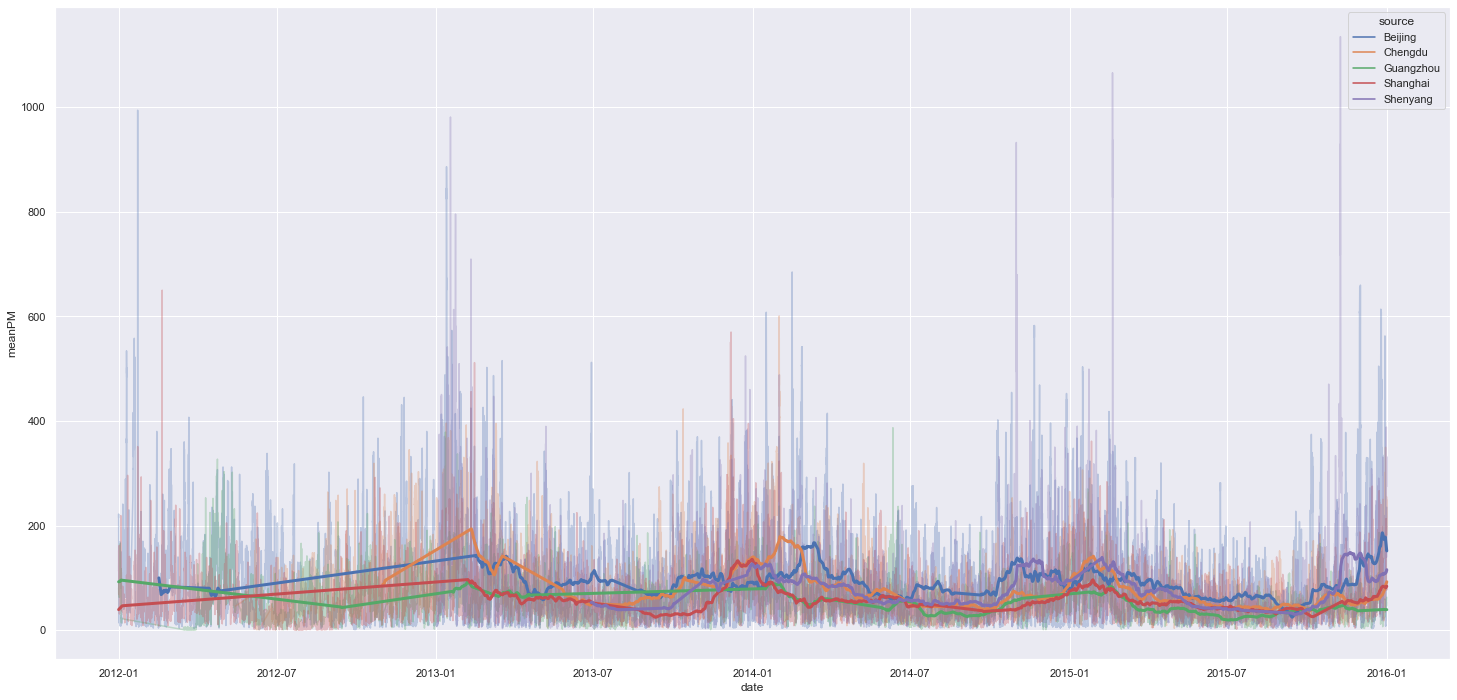

In [8]:
ax = sns.lineplot(data = df, x = 'date', y = 'meanPM', hue = 'source', alpha = 0.3)
ax = sns.lineplot(df.date, df.meanPM.rolling(24*30).mean(), hue = df.source, alpha = 1, legend = False, linewidth = 3)

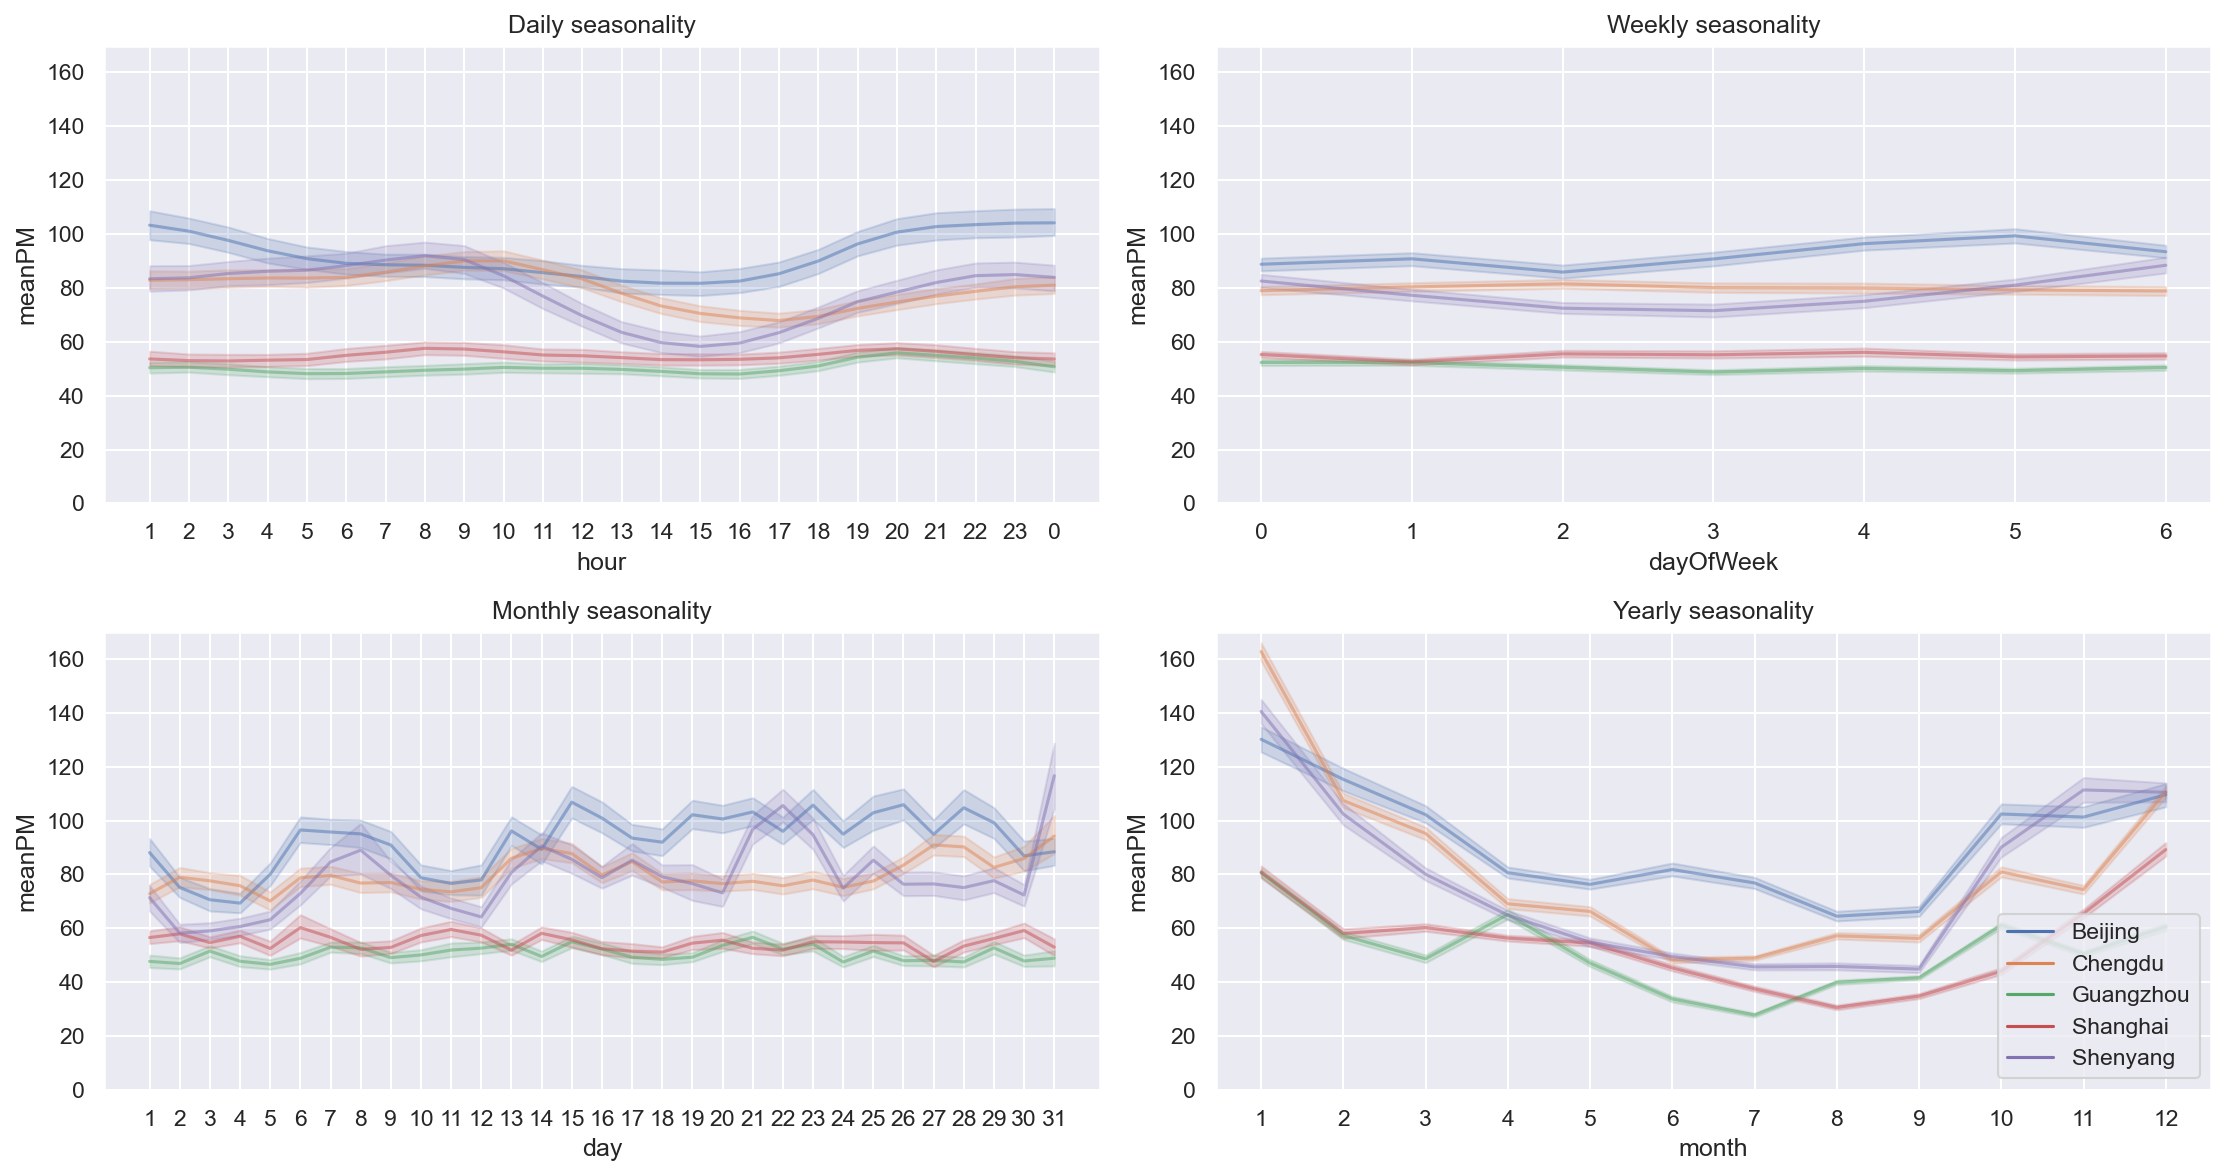

In [12]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 8), dpi = 150)

seasonality = {
    'hour'      : 'Daily seasonality',
    'dayOfWeek' : 'Weekly seasonality',
    'day'       : 'Monthly seasonality',
    'month'     : 'Yearly seasonality', 
}

for i, (col, title) in enumerate(seasonality.items()):
    sns.lineplot(data = df, x = col, y = 'meanPM', hue = 'source', alpha = 0.5, ax = axs[i//2, i%2]).set(title = title, ylim = (0, 170))
        
handles, labels = axs[1, 1].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))

plt.show()

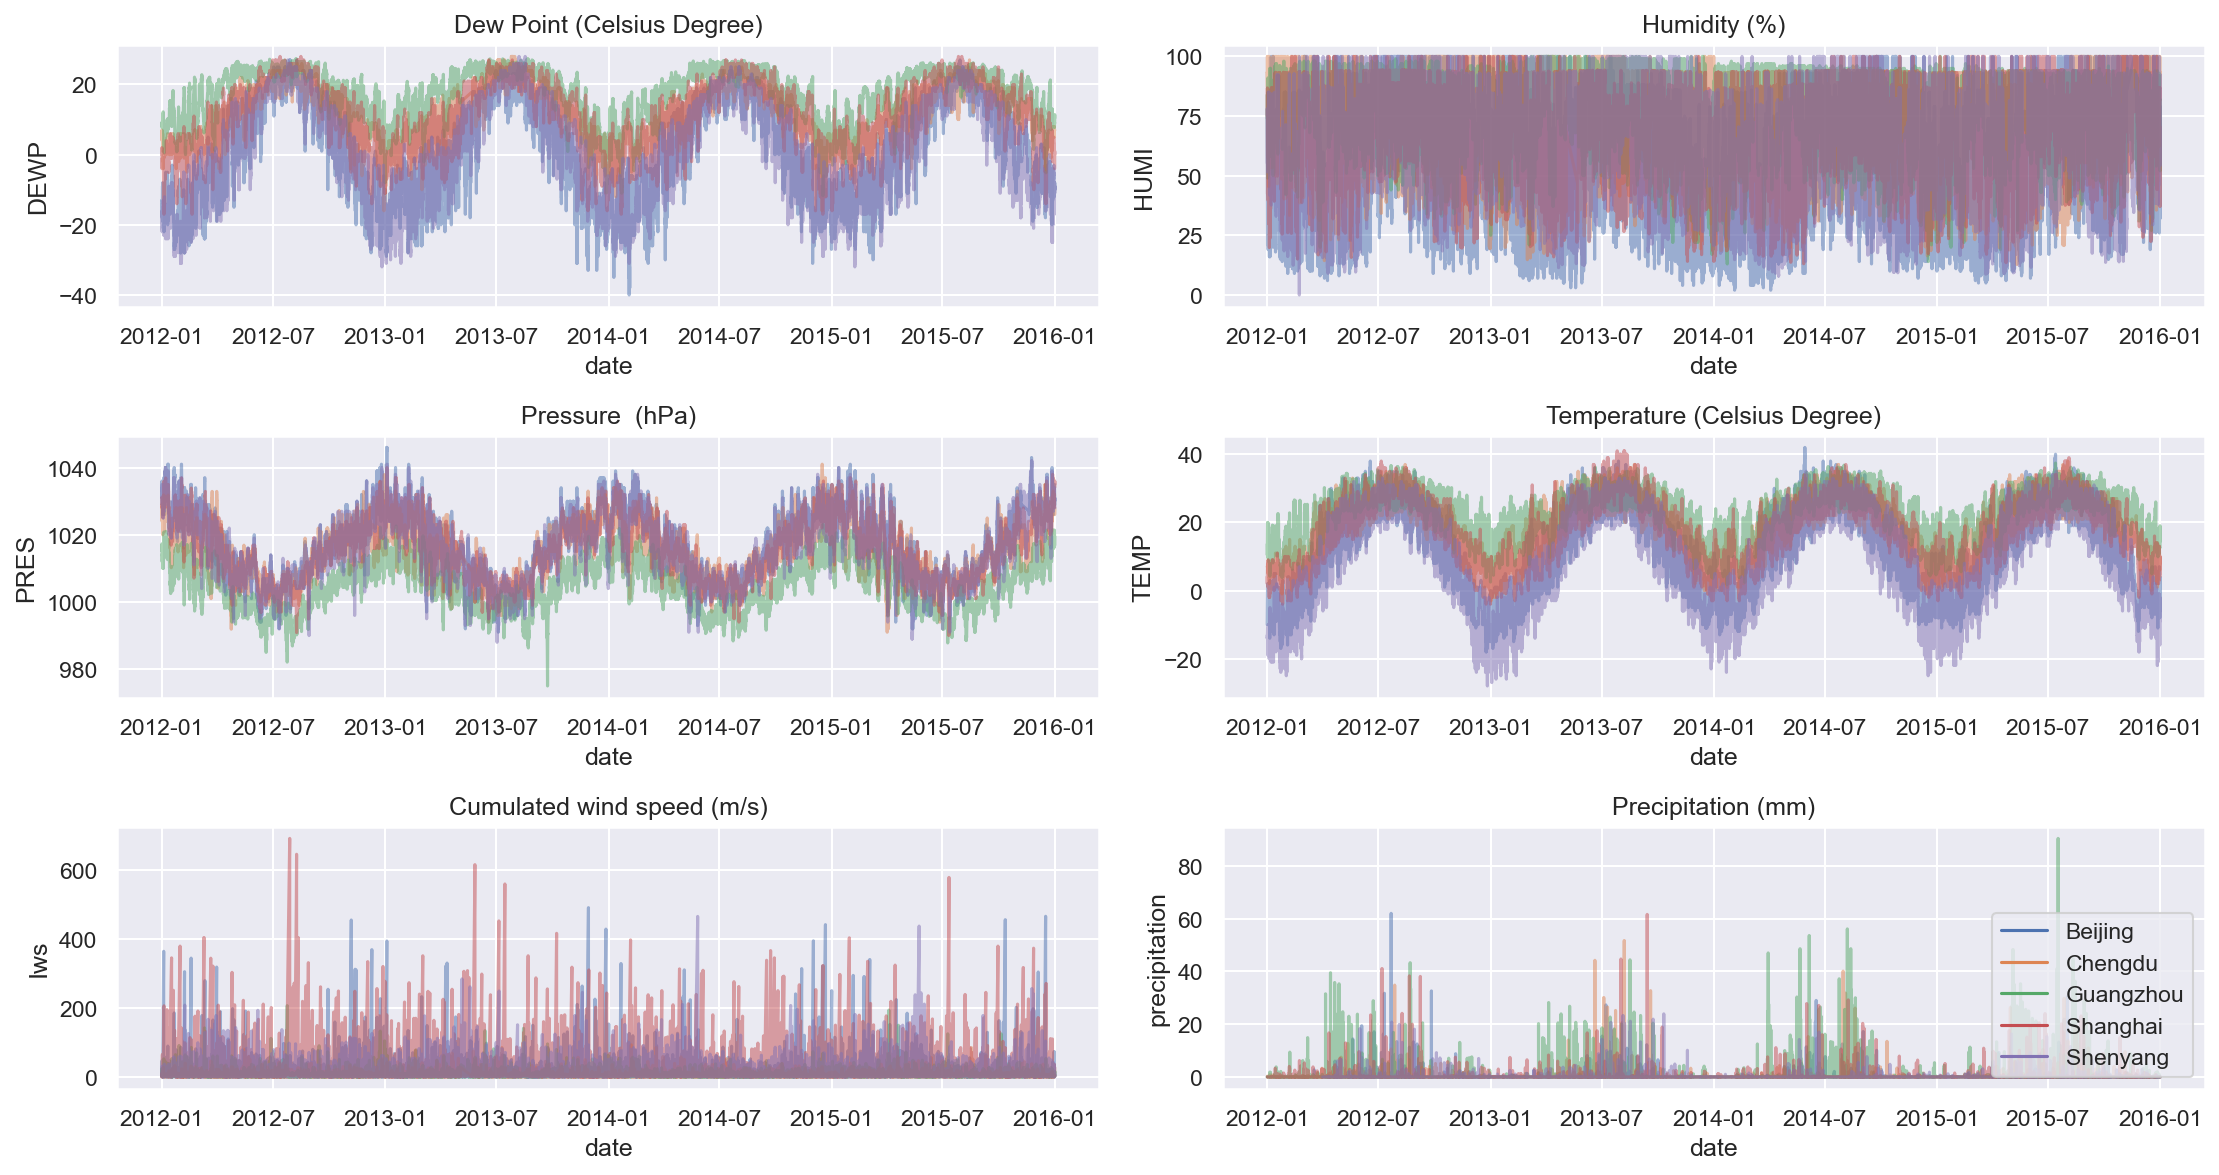

In [13]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 8), dpi = 150)

independentVariables = {
    'DEWP'           : 'Dew Point (Celsius Degree)',
    'HUMI'           : 'Humidity (%)',
    'PRES'           : 'Pressure  (hPa)', 
    'TEMP'           : 'Temperature (Celsius Degree)', 
    'Iws'            : 'Cumulated wind speed (m/s)', 
    'precipitation'  : 'Precipitation (mm)',
}

for i, (col, title) in enumerate(independentVariables.items()):
    sns.lineplot(data = df, x = 'date', y = col, hue = 'source', alpha = 0.5, ax = axs[i//2, i%2]).set(title = title)
    
handles, labels = axs[0, 0].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))

plt.show()


# Prediction

### Assumptions and data wrangling

In [26]:
def prepareTrainTestSet():
    df = loadRawData()

    ### Fill missing values in independent variables ###
    colsToFill = df.columns.to_list()
    colsToFill.remove('meanPM')

    # Missing values in the independent variables are rare, so they are just filled with the previous value
    df[colsToFill] = df[colsToFill].fillna(method = 'ffill').fillna(method = 'bfill')


    ### Lagging the variables ###
    independentCols = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation']
    df[independentCols] = df[independentCols].shift(24) # 24 hours lag

    df['meanPM_24h']  = df.groupby('source').shift(24).meanPM
    df['meanPM_7d']   = df.groupby('source').shift(24 * 7).meanPM
    df['meanPM_30d']  = df.groupby('source').shift(24 * 30).meanPM 
    df['meanPM_365d'] = df.groupby('source').shift(24 * 365).meanPM # later this sadly drops the first year of data
    

    ### Convert categorical to dummies ###
    catCols = ['source', 'month', 'day', 'hour', 'season', 'cbwd', 'dayOfWeek']
    temp = [df.drop(catCols, axis = 1)]
    temp.extend(pd.get_dummies(df[col], prefix = col) for col in catCols)
    df = pd.concat(temp, axis = 1)
    
    
    ### Designate last year (~20%) of the data as test set ###
    df['isTestSet'] = (df.date > datetime(2015, 1, 1)).astype(int)
    
    
    ### Scale the numerical columns ###
    numCols = ['meanPM', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'meanPM_24h', 'meanPM_7d', 'meanPM_30d', 'meanPM_365d']
    
    scaler = StandardScaler()
    scaler.fit(df[df.isTestSet == 0][numCols])
    
    df[numCols] = scaler.transform(df[numCols])
    
    
    ### Drop rows with NaN values ###
    # 35% of the dataset is dropped. This is just a quick analysis so it's ok
    # In a production model, the missing values should be investigated and filled with more sophisticated methods
    # e.g. using a moving average (but the gaps are wider than 24 hours, so it's not ideal)
    droppedRows = df.isnull().any(axis = 1).sum()
    percentOfTotal = (droppedRows / df.shape[0] * 100).round(2)
    #print(f'Dropping {droppedRows} ({percentOfTotal}%) rows with NaN')
    
    df = df[~df.isnull().any(axis = 1)].reset_index(drop = True)


    ### Drop unnecessary columns ###
    df = df.drop(['date', 'year'], axis = 1)


    ### Split the data into train and test sets ###
    independentCols = [col for col in df.columns if col not in ['meanPM', 'isTestSet', 'isDangerous']]
    
    X_train = df[df.isTestSet == 0][independentCols]
    X_test  = df[df.isTestSet == 1][independentCols]
    
    y_train = df[df.isTestSet == 0]['meanPM']
    y_test  = df[df.isTestSet == 1]['meanPM']

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepareTrainTestSet()

### Model results

In [17]:
regRF = RandomForestRegressor(n_estimators = 1000, max_depth = 10, random_state = 42, verbose = 0, n_jobs = -1)
regRF.fit(X_train, y_train)
regRF.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   40.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.354404101653947

In [18]:
pd.Series(regRF.feature_importances_, index = X_train.columns).sort_values(ascending = False).head(20) * 100

meanPM_24h         42.042290
DEWP                7.523801
PRES                6.090841
meanPM_30d          4.444219
meanPM_7d           3.275160
cbwd_cv             2.973958
meanPM_365d         2.892313
source_Beijing      2.615140
cbwd_NW             2.311247
HUMI                1.584966
month_1             1.512789
TEMP                1.502663
day_31              1.432938
Iws                 1.409106
day_12              1.394113
cbwd_SE             1.035609
source_Shenyang     0.984769
cbwd_NE             0.931350
month_10            0.871246
day_6               0.832260
dtype: float64